**Lightweight YOLOv12 Based Model with Enhanced Backbone for Sugarcane Stem Health Detection**<br>

*Pushpendra Kumar1,2*, Shaveta Arora1† and Shraddha Arora1†*
* 1*The Northcap University, Street, Gurugram, Haryana, India.
 2 KIET Group of Institutions, Ghaziabad, UP, India.*

---
This notebook provides the source code for our manuscript.  

This script proposes a new CNN modular block based on [GELAN block](
https://doi.org/10.48550/arXiv.2402.13616
);
The proposed model:

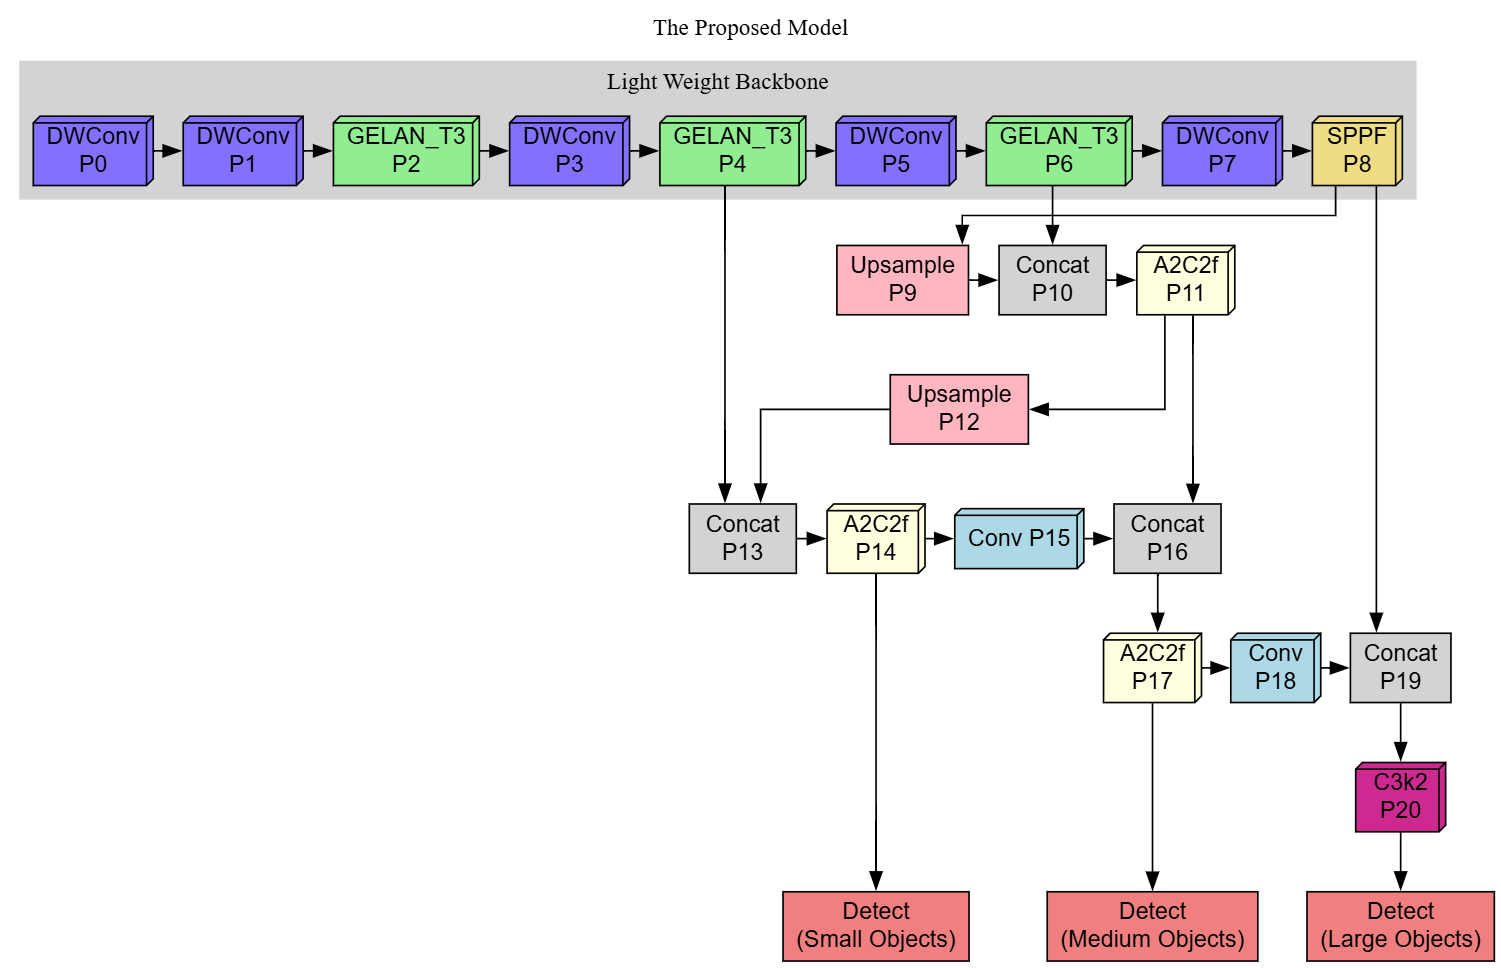


<h2>Clone ultralytics library from github</h2>

In [ ]:
!git clone https://github.com/ultralytics/ultralytics.git

Cloning into 'ultralytics'...
remote: Enumerating objects: 61530, done.
remote: Counting objects: 100% (438/438), done.
remote: Compressing objects: 100% (173/173), done.
remote: Total 61530 (delta 366), reused 271 (delta 265), pack-reused 61092 (from 3)
Receiving objects: 100% (61530/61530), 33.08 MiB | 27.52 MiB/s, done.
Resolving deltas: 100% (45803/45803), done.


<h2 style="color:green;">Check hardware, CPU and GPU config</h1>

In [ ]:
!nvidia-smi

Sun Jun  8 10:38:40 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 560.35.03              Driver Version: 560.35.03      CUDA Version: 12.6     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   49C    P8              9W /   70W |       1MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [ ]:
%cd ultralytics #change directory
!pip install -e '.[dev]' #install ultralytics in dev mode

/kaggle/working/ultralytics
Obtaining file:///kaggle/working/ultralytics
  Installing build dependencies ... done
  Checking if build backend supports build_editable ... done
  Getting requirements to build editable ... done
  Preparing editable metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.9/3.9 MB 38.9 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.7/8.7 MB 100.5 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.6 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.5 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 7.6 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 14.2 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 13.3 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 8.1 MB/s eta 0:00:000:00:01

In [ ]:
from IPython import display
display.clear_output()

import ultralytics
ultralytics.checks()

Ultralytics 8.3.152 🚀 Python-3.11.11 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
Setup complete ✅ (4 CPUs, 31.4 GB RAM, 6362.1/8062.4 GB disk)


In [ ]:
%pwd #check current working directory


'/kaggle/working/ultralytics'

<h2>Write a new configuration file with a Light weight backbone </h2>

In [ ]:
%%writefile /kaggle/working/ultralytics/ultralytics/cfg/models/12/conf.yaml
# Ultralytics 🚀 AGPL-3.0 License - https://ultralytics.com/license

# YOLO12 object detection model with P3/8 - P5/32 outputs
# Model docs: https://docs.ultralytics.com/models/yolo12
# Task docs: https://docs.ultralytics.com/tasks/detect

# Parameters
nc: 2 # number of classes
scales: # model compound scaling constants, i.e. 'model=yolo12n.yaml' will call yolo12.yaml with scale 'n'
  # [depth, width, max_channels]
  n: [0.50, 0.25, 1024] # summary: 272 layers, 2,602,288 parameters, 2,602,272 gradients, 6.7 GFLOPs
  s: [0.50, 0.50, 1024] # summary: 272 layers, 9,284,096 parameters, 9,284,080 gradients, 21.7 GFLOPs
  m: [0.50, 1.00, 512] # summary: 292 layers, 20,199,168 parameters, 20,199,152 gradients, 68.1 GFLOPs
  l: [1.00, 1.00, 512] # summary: 488 layers, 26,450,784 parameters, 26,450,768 gradients, 89.7 GFLOPs
  x: [1.00, 1.50, 512] # summary: 488 layers, 59,210,784 parameters, 59,210,768 gradients, 200.3 GFLOPs

# YOLO12n backbone- [-1, 1, GELAN_T3, [128, 128, 32, 3]]
backbone:
  - [-1, 1, DWConv, [64, 3, 2, 1, False]]# 0-P1/2
  - [-1, 1, DWConv, [128, 3, 2, 1, False]]# 1-P2/4
  - [-1, 2, GELAN_T3, [256]]
  - [-1, 1, DWConv, [256, 3, 2, 1, False]]  # 3-P3/8
  - [-1, 2, GELAN_T3, [512]]
  - [-1, 1, DWConv, [512, 3, 2, 1, False]]# 5-P4/16
  - [-1, 2, GELAN_T3, [1024]]
  - [-1, 1, DWConv, [1024, 3, 2, 1, False]]# 7-P5/32
  - [-1, 1, SPPF, [1024, 5]]  # 8

# YOLO12n head
head:
  - [-1, 1, nn.Upsample, [None, 2, "nearest"]]
  - [[-1, 6], 1, Concat, [1]] # cat backbone P4
  - [-1, 2, A2C2f, [512, False, -1]] # 11

  - [-1, 1, nn.Upsample, [None, 2, "nearest"]]
  - [[-1, 4], 1, Concat, [1]] # cat backbone P3
  - [-1, 2, A2C2f, [256, False, -1]] # 14

  - [-1, 1, Conv, [256, 3, 2]]
  - [[-1, 11], 1, Concat, [1]] # cat head P4
  - [-1, 2, A2C2f, [512, False, -1]] # 17

  - [-1, 1, Conv, [512, 3, 2]]
  - [[-1, 8], 1, Concat, [1]] # cat head P5
  - [-1, 2, C3k2, [1024, True]] # 20 (P5/32-large)

  - [[14, 17, 20], 1, Detect, [nc]] # Detect(P3, P4, P5)


Overwriting /kaggle/working/ultralytics/ultralytics/cfg/models/12/conf.yaml


Add the GELAN-T3 block and GhostConv Blocks to the ultralytics/nn/modules/block.py



```
# Ghost Block
class GhostBlock(nn.Module):
    def __init__(self, in_channels, out_channels, ratio=2, kernel_size=3, dw_kernel_size=3, stride=1):
        super(GhostBlock, self).__init__()
        init_channels = int(out_channels / ratio)
        new_channels = out_channels - init_channels

        self.primary_conv = nn.Sequential(
            nn.Conv2d(in_channels, init_channels, kernel_size, stride, padding=kernel_size//2, bias=False),
            nn.BatchNorm2d(init_channels),
            nn.ReLU(inplace=True)
        )

        self.cheap_operation = nn.Sequential(
            nn.Conv2d(init_channels, new_channels, dw_kernel_size, 1, padding=dw_kernel_size//2, groups=init_channels, bias=False),
            nn.BatchNorm2d(new_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        primary = self.primary_conv(x)
        cheap = self.cheap_operation(primary)
        return torch.cat([primary, cheap], dim=1)

# GELAN_T3 Block
class GELAN_T3(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(GELAN_T3, self).__init__()

        # Partition: split input channels
        self.partition1_channels = in_channels // 2
        self.partition2_channels = in_channels - self.partition1_channels

        # Ghost Blocks: stacked
        self.ghost1 = GhostBlock(self.partition2_channels, self.partition2_channels)
        self.ghost2 = GhostBlock(self.partition2_channels, self.partition2_channels)
        self.ghost3 = GhostBlock(self.partition2_channels, self.partition2_channels)

        # Final projection after concat
        self.project = nn.Conv2d(
            self.partition1_channels + 3 * self.partition2_channels,  # concat of 3 ghost blocks + partition1
            out_channels,
            kernel_size=1,
            bias=False
        )
        self.bn = nn.BatchNorm2d(out_channels)
        self.act = nn.ReLU(inplace=True)

    def forward(self, x):
        # Partition input channels
        x1, x2 = torch.split(x, [self.partition1_channels, self.partition2_channels], dim=1)

        # Ghost path
        g1 = self.ghost1(x2)
        g2 = self.ghost2(g1)
        g3 = self.ghost3(g2)

        # Concat 1: dense connections from each ghost block
        concat1 = torch.cat([g1, g2, g3], dim=1)

        # Concat 2: concat of partition1 and concat1
        concat2 = torch.cat([x1, concat1], dim=1)

        # Final projection
        out = self.project(concat2)
        out = self.bn(out)
        out = self.act(out)
        return out

```



In [ ]:
#overwrite ultralytics/nn/modules/block.py

Overwriting ultralytics/nn/modules/block.py


In [ ]:
#update and overwrite ultralytics/nn/tasks.py
#export new blocks;

Overwriting ultralytics/nn/tasks.py


In [ ]:
#update and overwrite ultralytics/nn/modules/__init__.py

Overwriting ultralytics/nn/modules/__init__.py


We are using Ipython magic functions to read, write and creating new files

* Download dataset

In [ ]:
#Download the prepared dataset from Roboflow
!pip install roboflow

from roboflow import Roboflow
rf = Roboflow(api_key="y4uzPDgeB6rEDxdHhxsW")
project = rf.workspace("buddetection").project("np_mynp")
version = project.version(5)
dataset = version.download("yolov8")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.8/85.8 kB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.8/66.8 kB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.9/49.9 MB 32.4 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 98.2 MB/s eta 0:00:00:00:0100:01
  Attempting uninstall: idna
    Found existing installation: idna 3.10
    Uninstalling idna-3.10:
      Successfully uninstalled idna-3.10
  Attempting uninstall: opencv-python-headless
    Found existing installation: opencv-python-headless 4.11.0.86
    Uninstalling opencv-python-headless-4.11.0.86:
      Successfully uninstalled opencv-python-headless-4.11.0.86
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
datasets 3.6.0 requires fsspec[http]<=2025.3.0,>=2023.1.0, but you have fsspec 2025.3.2 which is incompatible.
google-cola


Extracting Dataset Version Zip to np_mynp-5 in yolov8:: 100%|██████████| 5622/5622 [00:00<00:00, 5670.64it/s]


Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


1. Make the data1.yaml file to connect the dataset to the model

In [ ]:
%%writefile /kaggle/working/ultralytics/np_mynp-5/data1.yaml
names:
- FIT
- UNFIT
nc: 2
roboflow:
  license: CC BY 4.0
  project: np_mynp
  url: https://universe.roboflow.com/buddetection/np_mynp/dataset/5
  version: 5
  workspace: buddetection
test: /kaggle/working/ultralytics/np_mynp-5/test/images
train: /kaggle/working/ultralytics/np_mynp-5/train/images
val: /kaggle/working/ultralytics/np_mynp-5/valid/images


Writing /kaggle/working/ultralytics/np_mynp-5/data1.yaml


* Creat a new File train.py and add following code to it.

In [ ]:
%%writefile train.py

import warnings
warnings.filterwarnings('ignore')
from ultralytics import YOLO


if __name__ == '__main__':
    model = YOLO('ultralytics/cfg/models/12/conf.yaml')
    # model.load('yolov8n.pt') # loading pretrain weights

    results=model.train(data="np_mynp-5/data1.yaml", epochs=100, imgsz=640)

Overwriting train.py


1. Run train.py
2. The training will start
3. The model architecture, size, GFLOPs etc can be observed here
![An image](https://media.lordicon.com/icons/wired/outline/2612-training.gif)

In [ ]:
!python train.py

WARNING ⚠️ no model scale passed. Assuming scale='n'.
Ultralytics 8.3.146 🚀 Python-3.11.11 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=np_mynp-5/data1.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=100, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=ultralytics/cfg/models/12/conf.yaml, momentum=0.937, mosaic=1.0, multi_scale=False, name=train6, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_ma

<h1>!!!The Results Are Here!!!</h1>

```
100 epochs completed in 0.691 hours.
Optimizer stripped from /kaggle/working/ultralytics/runs/detect/train6/weights/last.pt, 3.3MB
Optimizer stripped from /kaggle/working/ultralytics/runs/detect/train6/weights/best.pt, 3.3MB

Validating /kaggle/working/ultralytics/runs/detect/train6/weights/best.pt...
Ultralytics 8.3.146 🚀 Python-3.11.11 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
conf summary: 146 layers, 1,515,774 parameters, 0 gradients, 4.5 GFLOPs
                 Class     Images  Instances      Box(P          R      mAP50  m
                   all        312        357      0.895      0.794      0.892      0.626
                   FIT        148        235       0.92      0.851      0.922      0.652
                 UNFIT        116        122      0.869      0.738      0.861        0.6
Speed: 0.2ms preprocess, 2.1ms inference, 0.0ms loss, 1.8ms postprocess per image
Results saved to /kaggle/working/ultralytics/runs/detect/train6

# This is formatted as code
```

* Update train.py for train the Original YOLOv12n model on our dataset
* Run train.py
* Observe the results

In [ ]:
%%writefile train.py

import warnings
warnings.filterwarnings('ignore')
from ultralytics import YOLO

if __name__ == '__main__':
    model = YOLO('ultralytics/cfg/models/12/yolo12.yaml')
    model.info()

Overwriting train.py


In [ ]:
#See the information YOLOv12 model(You can observe huge size, params and GFLOPs difference)
!python train.py

WARNING ⚠️ no model scale passed. Assuming scale='n'.
YOLO12 summary: 272 layers, 2,602,288 parameters, 2,602,272 gradients, 6.7 GFLOPs


In [ ]:
%%writefile train.py

import warnings
warnings.filterwarnings('ignore')
from ultralytics import YOLO


if __name__ == '__main__':
    model = YOLO('ultralytics/cfg/models/12/yolo12.yaml')
    # model.load('yolov8n.pt') # loading pretrain weights

    results=model.train(data="np_mynp-5/data1.yaml", epochs=100, imgsz=640)

Overwriting train.py


* Start the training on YOLOv12n model

In [ ]:
!python train.py

WARNING ⚠️ no model scale passed. Assuming scale='n'.
Ultralytics 8.3.151 🚀 Python-3.11.11 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=np_mynp-5/data1.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=100, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=ultralytics/cfg/models/12/yolo12.yaml, momentum=0.937, mosaic=1.0, multi_scale=False, name=train, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_m


* Results from YOLOv12n are as Follows

```
100 epochs completed in 1.070 hours.
Optimizer stripped from /kaggle/working/ultralytics/runs/detect/train/weights/last.pt, 5.5MB
Optimizer stripped from /kaggle/working/ultralytics/runs/detect/train/weights/best.pt, 5.5MB

Validating /kaggle/working/ultralytics/runs/detect/train/weights/best.pt...
Ultralytics 8.3.151 🚀 Python-3.11.11 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
YOLO12 summary (fused): 159 layers, 2,557,118 parameters, 0 gradients, 6.3 GFLOPs
                 Class     Images  Instances      Box(P          R      mAP50  m
                   all        312        357      0.852      0.802      0.901      0.627
                   FIT        148        235      0.877      0.864      0.925       0.65
                 UNFIT        116        122      0.826      0.741      0.877      0.603
Speed: 0.2ms preprocess, 4.2ms inference, 0.0ms loss, 2.6ms postprocess per image
Results saved to /kaggle/working/ultralytics/runs/detect/train
```



<h1>Start Training on YOLOv11n model </h1>

In [ ]:
%%writefile train.py

import warnings
warnings.filterwarnings('ignore')
from ultralytics import YOLO

if __name__ == '__main__':
    model = YOLO('ultralytics/cfg/models/11/yolo11.yaml')
    model.info()

Overwriting train.py


In [ ]:
!python train.py

WARNING ⚠️ no model scale passed. Assuming scale='n'.
YOLO11 summary: 181 layers, 2,624,080 parameters, 2,624,064 gradients, 6.6 GFLOPs


In [ ]:
%%writefile train.py

import warnings
warnings.filterwarnings('ignore')
from ultralytics import YOLO


if __name__ == '__main__':
    model = YOLO('ultralytics/cfg/models/11/yolo11.yaml')
    # model.load('yolov8n.pt') # loading pretrain weights

    results=model.train(data="np_mynp-5/data1.yaml", epochs=100, imgsz=640)

Overwriting train.py


In [ ]:
!python train.py

WARNING ⚠️ no model scale passed. Assuming scale='n'.
Ultralytics 8.3.151 🚀 Python-3.11.11 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=np_mynp-5/data1.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=100, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=ultralytics/cfg/models/11/yolo11.yaml, momentum=0.937, mosaic=1.0, multi_scale=False, name=train2, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_

* YOLOv11n Results


```
100 epochs completed in 0.784 hours.
Optimizer stripped from /kaggle/working/ultralytics/runs/detect/train2/weights/last.pt, 5.5MB
Optimizer stripped from /kaggle/working/ultralytics/runs/detect/train2/weights/best.pt, 5.5MB

Validating /kaggle/working/ultralytics/runs/detect/train2/weights/best.pt...
Ultralytics 8.3.151 🚀 Python-3.11.11 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
YOLO11 summary (fused): 100 layers, 2,582,542 parameters, 0 gradients, 6.3 GFLOPs
                 Class     Images  Instances      Box(P          R      mAP50  m
                   all        312        357       0.86      0.813      0.906      0.642
                   FIT        148        235      0.905      0.868      0.933      0.652
                 UNFIT        116        122      0.815      0.759       0.88      0.632
Speed: 0.2ms preprocess, 2.4ms inference, 0.0ms loss, 1.9ms postprocess per image
Results saved to /kaggle/working/ultralytics/runs/detect/train2
```



* Train on YOLOv8n

In [ ]:
%%writefile train.py

import warnings
warnings.filterwarnings('ignore')
from ultralytics import YOLO


if __name__ == '__main__':
    model = YOLO('ultralytics/cfg/models/v8/yolov8.yaml')
    # model.load('yolov8n.pt') # loading pretrain weights
    results=model.train(data="/kaggle/working/ultralytics/np_mynp-5/data1.yaml", epochs=100, batch=16, imgsz=640)

Overwriting train.py


In [ ]:
!python train.py

WARNING ⚠️ no model scale passed. Assuming scale='n'.
Ultralytics 8.3.102 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: task=detect, mode=train, model=ultralytics/cfg/models/v8/yolov8.yaml, data=/kaggle/working/ultralytics/np_mynp-5/data1.yaml, epochs=100, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train2, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_fr

YOLOv8n Results

```
100 epochs completed in 0.669 hours.
Optimizer stripped from /kaggle/working/ultralytics/runs/detect/train2/weights/last.pt, 6.3MB
Optimizer stripped from /kaggle/working/ultralytics/runs/detect/train2/weights/best.pt, 6.3MB

Validating /kaggle/working/ultralytics/runs/detect/train2/weights/best.pt...
Ultralytics 8.3.102 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8 summary (fused): 72 layers, 3,006,038 parameters, 0 gradients, 8.1 GFLOPs
                 Class     Images  Instances      Box(P          R      mAP50  m
                   all        312        357       0.82      0.844      0.894      0.642
                   FIT        148        235      0.899      0.869      0.923      0.667
                 UNFIT        116        122      0.742       0.82      0.865      0.616
Speed: 0.3ms preprocess, 2.2ms inference, 0.0ms loss, 2.3ms postprocess per image
Results saved to /kaggle/working/ultralytics/runs/detect/train2
```



* Train for YOLOv9n

In [ ]:
%%writefile train.py

import warnings
warnings.filterwarnings('ignore')
from ultralytics import YOLO


if __name__ == '__main__':
    model = YOLO('ultralytics/cfg/models/v9/yolov9t.yaml')
    # model.load('yolov8n.pt') # loading pretrain weights
    results=model.train(data="/kaggle/working/ultralytics/np_mynp-5/data1.yaml", epochs=100, batch=16, imgsz=640)

Overwriting train.py


In [ ]:
!python train.py

Ultralytics 8.3.102 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: task=detect, mode=train, model=ultralytics/cfg/models/v9/yolov9t.yaml, data=/kaggle/working/ultralytics/np_mynp-5/data1.yaml, epochs=100, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train4, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_cro

YOLOv9n Results

```
100 epochs completed in 1.027 hours.
Optimizer stripped from /kaggle/working/ultralytics/runs/detect/train4/weights/last.pt, 4.6MB
Optimizer stripped from /kaggle/working/ultralytics/runs/detect/train4/weights/best.pt, 4.6MB

Validating /kaggle/working/ultralytics/runs/detect/train4/weights/best.pt...
Ultralytics 8.3.102 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15095MiB)
YOLOv9t summary (fused): 197 layers, 1,971,174 parameters, 0 gradients, 7.6 GFLOPs
                 Class     Images  Instances      Box(P          R      mAP50  m
                   all        312        357      0.864      0.818      0.913      0.643
                   FIT        148        235       0.92      0.847      0.934      0.658
                 UNFIT        116        122      0.807      0.789      0.891      0.629
Speed: 0.2ms preprocess, 3.0ms inference, 0.0ms loss, 1.6ms postprocess per image
Results saved to /kaggle/working/ultralytics/runs/detect/train4
```



* Train On YOLOv10n

In [ ]:
%%writefile train.py

import warnings
warnings.filterwarnings('ignore')
from ultralytics import YOLO


if __name__ == '__main__':
    model = YOLO('ultralytics/cfg/models/v10/yolov10n.yaml')
    # model.load('yolov8n.pt') # loading pretrain weights
    results=model.train(data="/kaggle/working/ultralytics/np_mynp-5/data1.yaml", epochs=100, batch=16, imgsz=640)

Overwriting train.py


In [ ]:
!python train.py

Ultralytics 8.3.102 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: task=detect, mode=train, model=ultralytics/cfg/models/v10/yolov10n.yaml, data=/kaggle/working/ultralytics/np_mynp-5/data1.yaml, epochs=100, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train5, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_c

YOLOv10n Results

```
100 epochs completed in 0.865 hours.
Optimizer stripped from /kaggle/working/ultralytics/runs/detect/train5/weights/last.pt, 5.8MB
Optimizer stripped from /kaggle/working/ultralytics/runs/detect/train5/weights/best.pt, 5.8MB

Validating /kaggle/working/ultralytics/runs/detect/train5/weights/best.pt...
Ultralytics 8.3.102 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15095MiB)
YOLOv10n summary (fused): 125 layers, 2,695,196 parameters, 0 gradients, 8.2 GFLOPs
                 Class     Images  Instances      Box(P          R      mAP50  m
                   all        312        357      0.907       0.73      0.867      0.589
                   FIT        148        235      0.906      0.813      0.905      0.625
                 UNFIT        116        122      0.908      0.647      0.828      0.552
Speed: 0.2ms preprocess, 3.3ms inference, 0.0ms loss, 0.3ms postprocess per image
Results saved to /kaggle/working/ultralytics/runs/detect/train5
```



In [ ]:
#this code is for downloading the results, models etc.
import shutil

# Zip the 'runs' directory
shutil.make_archive("runs_backup", 'zip', "runs")

print("Zipping complete! File saved as runs_backup.zip")


Zipping complete! File saved as runs_backup.zip


* Train on YOLOv5n

In [ ]:
%%writefile train.py

import warnings
warnings.filterwarnings('ignore')
from ultralytics import YOLO


if __name__ == '__main__':
    model = YOLO('ultralytics/cfg/models/v5/yolov5.yaml')
    # model.load('yolov8n.pt') # loading pretrain weights
    #results=model.train(data="/kaggle/working/ultralytics/np_mynp-5/data1.yaml", epochs=100, batch=16, imgsz=640,optimizer='SGD',close_mosaic=10,)
    model.info()

Writing train.py


In [ ]:
!python train.py

WARNING ⚠️ no model scale passed. Assuming scale='n'.
YOLOv5 summary: 153 layers, 2,654,816 parameters, 2,654,800 gradients, 7.8 GFLOPs


In [ ]:
%%writefile train.py

import warnings
warnings.filterwarnings('ignore')
from ultralytics import YOLO


if __name__ == '__main__':
    model = YOLO('ultralytics/cfg/models/v5/yolov5.yaml')
    # model.load('yolov8n.pt') # loading pretrain weights
    results=model.train(data="/kaggle/working/ultralytics/np_mynp-5/data1.yaml", epochs=100, batch=16, imgsz=640)
    #model.info()

Overwriting train.py


* Train on YOLOv6n

In [ ]:
%%writefile train.py

import warnings
warnings.filterwarnings('ignore')
from ultralytics import YOLO


if __name__ == '__main__':
    model = YOLO('ultralytics/cfg/models/v6/yolov6n.yaml')
    # model.load('yolov8n.pt') # loading pretrain weights
    #results=model.train(data="/kaggle/working/ultralytics/np_mynp-5/data1.yaml", epochs=100, batch=16, imgsz=640)
    model.info()

Writing train.py


In [ ]:
!python train.py

YOLOv6n summary: 121 layers, 4,500,080 parameters, 4,500,064 gradients, 13.1 GFLOPs


In [ ]:
%%writefile train.py

import warnings
warnings.filterwarnings('ignore')
from ultralytics import YOLO


if __name__ == '__main__':
    model = YOLO('ultralytics/cfg/models/v6/yolov6n.yaml')
    # model.load('yolov8n.pt') # loading pretrain weights
    results=model.train(data="/kaggle/working/ultralytics/np_mynp-5/data1.yaml", epochs=100, batch=16, imgsz=640)
    #model.info()

Writing train.py


In [ ]:
import shutil

# Zip the 'runs' directory
shutil.make_archive("runs_backup_n", 'zip', "runs")

print("Zipping complete! File saved as runs_backup.zip")

Zipping complete! File saved as runs_backup.zip
